In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_dir = '/content/drive/MyDrive/Project'

Just run "dataset," "model," and "train"

# **preprocessing_class_gpu**

In [ ]:
import numpy as np
import pickle as pk
import time
import os
import torch

#VERSION='V0.12'

class radarConfig():
    def __init__(self):
        self.NUM_TX = 3
        self.NUM_TX_LOWER = 2
        self.NUM_RX = 4
        self.NUM_TRX = 3*4
        self.NUM_TRX_LOWER = 2*4
        self.CHIRP_LOOPS = 128
        self.ADC_SAMPLES = 256
        self.NUM_RANGE_BINS = self.ADC_SAMPLES
        self.NUM_DOPPLER_BINS=self.CHIRP_LOOPS
        self.crop_dop_size=64

        self.FRAME_SIZE= self.NUM_TX * self.NUM_RX * self.CHIRP_LOOPS * self.ADC_SAMPLES

        self.FRAME_BYTE_SIZE= self.FRAME_SIZE*4
        self.FRAME_INT16_SIZE= self.FRAME_SIZE*2
        self.FRAME_COMPLEX_SIZE= self.FRAME_SIZE

        self.FPS=10

class PreprocessGPU():
    def __init__(self, opts):
        self.cfg=radarConfig()
        self.opts=opts
        self.gpu_device=self.opts.gpu_device
        self.range_bin_size=opts.range_bin_size
        self.range_bin_begin=opts.range_bin_begin
        self.range_bin_end=self.range_bin_begin+self.range_bin_size

        if opts.MVDR1D_format=='XY':
            self.steer_mat, self.r_idx_mat=self._init_steer_mat_X_Y_bin_version_gpu(
                antenna_size=self.cfg.NUM_TRX,
                x_bin_size=self.opts.x_bin_size,
                y_bin_size=self.opts.y_bin_size,
                y_bin_begin=self.range_bin_begin,
                bin_len=4.0)  # (128, 128, 8) (128, 128)
        elif opts.MVDR1D_format=='XR':
            pass
        else:
            raise ValueError


        #self.invalid_mask=np.logical_not(self.valid_mask)
        #self.angle_mean=-4.69
        #self.angle_std=0.25
        #self.doppler_mean=-2.72
        #self.doppler_std=0.34
        #self.train_idx_begin=0
        #self.train_idx_end=2400
        #self.save_np_mat(self.valid_mask, self.out_location+'mask.npy')
        #self.piece_length=8

    def fft_with_window_gpu(self, mat, axis=-1, shift_flag=False):
        mat_shape=mat.shape
        dim=np.ones_like(mat_shape, dtype=int)
        dim[axis]=mat_shape[axis]
        wd=torch.hamming_window(mat_shape[axis], periodic=False, alpha=0.54, beta=0.46,dtype=torch.float32).reshape(tuple(dim)).to(self.gpu_device)
        result=torch.fft.fft(mat*wd, dim=axis)
        if shift_flag:
            result=torch.fft.fftshift(result, dim=axis)
        return result

    def stft_with_window_gpu(self,mat, window_lenth, hop_length, shift_flag=True):
        wd = torch.hamming_window(window_lenth, periodic=False, alpha=0.54, beta=0.46, dtype=torch.float32).to(self.gpu_device)
        time_doppler = torch.stft(mat, window_lenth, hop_length, window=wd, center=False)
        if shift_flag:
            time_doppler = torch.fft.fftshift(time_doppler, dim=1)
        return time_doppler
    def clutter_removal_gpu(self, mat, axis=-2): # axis on the chirp dimension
        return mat-mat.mean(dim=axis, keepdims=True)

    def _init_steer_mat_X_Y_bin_version_gpu(self, antenna_size, x_bin_size, y_bin_size, y_bin_begin, bin_len): # one bin represents 4 cm for both X and Y, 4.3 for R, y_bin_begin start from 0, bin_len unit: cm
        x_vec=(np.expand_dims(np.arange(x_bin_size-1, -1, -1, dtype=np.float64), axis=1)-(x_bin_size)//2)*bin_len
        y_vec=np.expand_dims(np.arange(y_bin_begin, y_bin_size+y_bin_begin, dtype=np.float64), axis=0)*bin_len
        r_mat=np.sqrt(np.square(x_vec)+np.square(y_vec))
        r_idx_mat=(r_mat/4.3).astype(np.int64) #(x_bin_size, y_bin_size)
        sin_mat=x_vec/r_mat
        #sin_mat=np.clip(sin_mat, -1.0, 1.0)
        steer_mat=[]
        for i in range(antenna_size):
            if i<8:
                steer_mat.append(np.exp(-1j*i*np.pi*sin_mat))
            else:
                steer_mat.append(np.exp(-1j*(i-6)*np.pi*sin_mat))
        steer_mat=np.stack(steer_mat, axis=0) #(antenna_size,x_bin_size,y_bin_size)
        steer_mat=steer_mat.transpose((1,2,0))
        return torch.from_numpy(steer_mat).cfloat().to(self.gpu_device), torch.from_numpy(r_idx_mat).long().to(self.gpu_device)

    def cal_X_Y_plane_MVDR1D_energy_MP_batch_gpu(self, rfft, steer_mat): #(batch, 128, 128, 12, 128), (128, 128, 12)
        #time_begin=time.time()
        #print('#########################')
        x_mat=rfft #(batch, 128, 128, 12, 128)
        xH_mat=torch.conj(rfft.permute(0,1,2,4,3)) #(batch, 128, 128, 128, 8)
        R_mat=torch.matmul(x_mat, xH_mat) #(batch,128,128,12,12)
        R_mat=R_mat.cfloat()
        #time_tmp=time.time()
        R_1_mat=torch.linalg.pinv(R_mat, hermitian=True) #(batch,128,128,12,12)
        #print('pinv: %.1f'%(time.time()-time_tmp))
        R_1_mat=R_1_mat.cfloat()
        a_mat=steer_mat[None,:,:,:,None] #(1,128,128,12,1)
        aH_mat=torch.conj(steer_mat)[None,:,:,None,:] #(1,128,128,1,12)
        p_mat=1/torch.matmul(torch.matmul(aH_mat, R_1_mat), a_mat)
        data=torch.abs(p_mat.squeeze(-1).squeeze(-1))
        #print('MVDR time: %.1f'%(time.time()-time_begin))
        #print('#########################')
        return data #(batch, 128, 128)

    #def normalize_mean_std(self, mat, m, s):
    #    return (mat-m)/s

    def get_magnitude(self, n):
        return torch.floor(torch.log10(n))

    def normalize_base_exp(self, mat, base, exp):
        mat=torch.log10(mat-mat.amin(dim=(1,2), keepdim=True)+base)-exp
        return mat/mat.amax(dim=(1,2), keepdim=True)

    def normalize_exp_sim(self, mat, exp):
        mat=mat*(10**exp)
        mat=torch.log10(mat-mat.amin(dim=(1,2), keepdim=True)+10)-1
        return mat/mat.amax(dim=(1,2), keepdim=True)

    def normalize_base_exp_single(self, mat, base, exp):
        mat = torch.log10(mat - mat.min() + base) - exp
        return mat / mat.max()

    def normalize_quantile_single(self,mat):
        mat_flat = mat.reshape(-1)
        q_value = torch.quantile(mat_flat, self.opts.quantile_q, dim=0).reshape((1, 1))
        mat = mat / q_value
        mat = torch.log10(mat - mat.amin(dim=(0, 1), keepdim=True) + 1)
        return mat / mat.amax(dim=(0, 1), keepdim=True)

    def normalize_ang_sim(self, mat):
        mat_flat=mat.reshape((mat.shape[0], -1))
        mag=self.get_magnitude(torch.quantile(mat_flat, 0.9, dim=1)).reshape((mat.shape[0], 1, 1))
        mat=mat/(10**mag)
        mat=torch.log10(mat-mat.amin(dim=(1,2), keepdim=True)+1)
        return mat/mat.amax(dim=(1,2), keepdim=True)

    def normalize_quantile(self, mat):
        mat_flat=mat.reshape((mat.shape[0], -1))
        q_value=torch.quantile(mat_flat, self.opts.quantile_q, dim=1).reshape((mat.shape[0], 1, 1))
        mat=mat/q_value
        mat=torch.log10(mat-mat.amin(dim=(1,2), keepdim=True)+1)
        return mat/mat.amax(dim=(1,2), keepdim=True)

    def reordered(self, mat): #(batch, 12, 128, 128)
        #batch, ant, height, width=mat.shape
        return mat[:,:,:,self.r_idx_mat].transpose((0,3,4,1,2)) #(batch, 128, 128, 12, 128)

    def reordered_gpu(self, mat): #(batch, 12, 128, 128)
        #batch, ant, height, width=mat.shape
        return mat[:,:,:,self.r_idx_mat].permute((0,3,4,1,2)) #(batch, 128, 128, 12, 128)

    def get_processed_frames_gpu(self, frames_tensor):
        batch_length=frames_tensor.shape[0]
        frames_range=self.fft_with_window_gpu(frames_tensor, axis=-1, shift_flag=False)
        if self.opts.flag_allow_scr and self.opts.input_type=='raw': # no need on sim
            frames_range=self.clutter_removal_gpu(frames_range, axis=-2)

        # dop
        channel_doppler=self.fft_with_window_gpu(frames_range[...,self.range_bin_begin:self.range_bin_end], axis=-2, shift_flag=True)
        channel_doppler=\
            torch.abs(torch.mean(channel_doppler, axis=(1,2)))[:,
            self.cfg.CHIRP_LOOPS//2-self.cfg.crop_dop_size//2:self.cfg.CHIRP_LOOPS//2+self.cfg.crop_dop_size//2,:] #(batch_length, 128, 256)
        #channel_doppler=self.normalize_mean_std(channel_doppler, self.doppler_mean, self.doppler_std)
        if self.opts.flag_use_normalization:
            if self.opts.normalization_mode=='threshold':
                if self.opts.input_type=='raw':
                    channel_doppler=self.normalize_base_exp(channel_doppler, self.opts.dop_base, self.opts.dop_exp)
                elif self.opts.input_type=='sim':
                    channel_doppler=self.normalize_exp_sim(channel_doppler, self.opts.dop_exp)
                else:
                    raise ValueError
            elif self.opts.normalization_mode=='quantile':
                channel_doppler=self.normalize_quantile(channel_doppler)
            else:
                raise ValueError

        # ang
        channel_angle=frames_range.reshape(batch_length, self.cfg.NUM_TX*self.cfg.NUM_RX, self.cfg.CHIRP_LOOPS, self.cfg.ADC_SAMPLES) #(batch_length, 8, 128, 256)
        channel_angle=self.reordered_gpu(channel_angle)
        channel_angle=self.cal_X_Y_plane_MVDR1D_energy_MP_batch_gpu(channel_angle, self.steer_mat) #(batch_length, 128, 256)
        #channel_angle=torch.log10(channel_angle)
        #channel_angle=self.normalize_mean_std(channel_angle, self.angle_mean, self.angle_std)
        if self.opts.flag_use_normalization:
            if self.opts.normalization_mode=='threshold':
                if self.opts.input_type=='raw':
                    channel_angle=self.normalize_base_exp(channel_angle, self.opts.ang_base, self.opts.ang_exp)
                elif self.opts.input_type=='sim':
                    channel_angle=self.normalize_ang_sim(channel_angle)
                else:
                    raise ValueError
            elif self.opts.normalization_mode=='quantile':
                channel_angle=self.normalize_quantile(channel_angle)
            else:
                raise ValueError

        if self.opts.flag_use_normalization:
            channel_angle=channel_angle*2-1
            channel_doppler=channel_doppler*2-1
        return channel_angle, channel_doppler

    def get_time_doppler(self, data):
        batch_size, length_size, tx_size, rx_size, chirp_loops, adc_samples = data.shape
        data = data.view(batch_size * length_size, tx_size, rx_size, chirp_loops, adc_samples)
        data = torch.permute(data, (1, 2, 0, 3, 4)).view(tx_size * rx_size, batch_size * length_size, chirp_loops,
                                                         adc_samples)
        with torch.no_grad():
            data = data.cfloat().to(self.gpu_device)
            frames_tensor = data

            frames_range = self.fft_with_window_gpu(frames_tensor, axis=-1, shift_flag=False)  # 为true的话，0就在中间了
            frames_range = self.clutter_removal_gpu(frames_range, axis=-2)#[..., 10:30]  # 不用的话，zero-velocity上会有很多值

            # b*tx*rx*chrip*adc
            # find max along adc, and get 128(chirp)*1 vector
            max_index = torch.argmax(torch.abs(frames_range), dim=-1)

            range_max = frames_range[torch.arange(tx_size * rx_size)[:, None, None],
                                     torch.arange(batch_size * length_size)[:, None],
                                     torch.arange(chirp_loops),
                                     max_index] \
                .view(tx_size * rx_size, batch_size * length_size * chirp_loops)
            # print(range_max.shape)

            time_doppler = self.stft_with_window_gpu(range_max, window_lenth=256, hop_length=64, shift_flag=True)
            time_doppler = torch.abs(torch.mean(time_doppler, dim=0))
            time_doppler=time_doppler[time_doppler.shape[0]//2-32:time_doppler.shape[0]//2+32]
            # time_doppler = self.normalize_base_exp_single(time_doppler, self.opts.ang_base, self.opts.ang_exp)
            time_doppler = self.normalize_quantile_single(time_doppler)

            print(time_doppler.shape)
            return time_doppler


    def preprocess_batch_length_data(self, data, noise_level=1.0): #torch_tensor, cfloat, (batch,length,3,4,128,256)
        #time_begin=time.time()
        batch_size, length_size, tx_size, rx_size, chirp_loops, adc_samples=data.shape
        data=data.view(batch_size*length_size, tx_size, rx_size, chirp_loops, adc_samples)
        with torch.no_grad():
            data=data.cfloat().to(self.gpu_device)
            if self.opts.flag_add_noise and noise_level>0:
                med=torch.median(torch.abs(data))
                data+=(torch.randn(data.shape, device=data.device)+1j*torch.randn(data.shape, device=data.device))*med*self.opts.noise_rate*noise_level

            frame_size=data.shape[0]
            piece_length=self.opts.piece_length
            piece_size=frame_size//piece_length
            if frame_size%piece_length!=0:
                piece_size+=1
            #print('piece_size:', piece_size)
            ang_list=[]
            dop_list=[]
            time_fre_list=[]
            for piece_no in range(piece_size):
                ang, dop=self.get_processed_frames_gpu(data[piece_length*piece_no: piece_length*(piece_no+1)])
                ang_list.append(ang)
                dop_list.append(dop)
            if self.opts.MVDR1D_format=='XY':
                ang_tensor=torch.cat(ang_list, dim=0).view(batch_size, length_size, self.opts.x_bin_size, self.opts.y_bin_size)
            elif self.opts.MVDR1D_format=='XR':
                ang_tensor=torch.cat(ang_list, dim=0).view(batch_size, length_size, self.opts.x_bin_size, self.opts.range_bin_size)
            dop_tensor=torch.cat(dop_list, dim=0).view(batch_size, length_size, self.cfg.crop_dop_size, self.opts.range_bin_size)
        if self.opts.flag_cat_ang_dop:
            cat_tensor=torch.stack((ang_tensor, dop_tensor), dim=-3)
            return cat_tensor
        else:
            return ang_tensor, dop_tensor

def save_img(data, outname):
    plt.imshow(data)
    plt.savefig(outname, bbox_inches='tight', dpi=300)
    plt.clf()

if __name__=='__main__':
    from raw_opts import OPTS
    opts=OPTS()
    cur_device=torch.device('cpu')
    opts.gpu_device=cur_device

    #if_location='./s104-rawIF/'
    #out_location='./s104-rawIF-img/'
    if_location='./s104-simIF/'
    out_location='./s104-simIF-img/'
    if not os.path.isdir(out_location):
        os.system('mkdir %s'%(out_location))
        os.system('mkdir %sdop/'%(out_location))
        os.system('mkdir %sang/'%(out_location))
    frame_length=16 #150
    ifdata=[]
    for i in range(frame_length):
        ifdata.append(np.load(if_location+'%04d.npy'%(i)))
    ifdata=torch.from_numpy(np.asarray(ifdata).reshape((2,8,3,4,128,256))).to(cur_device)
    print(ifdata.shape, ifdata.dtype)
    #for i in range(frame_length):
    #    x=torch.abs(ifdata[i])
    #    print(x.max(), torch.median(x), x.mean(), x.min())
    #exit()
    
    p=PreprocessGPU(opts)
    cat=p.preprocess_batch_length_data(ifdata, 0.0)
    print(cat.shape, cat.requires_grad)
    for i in range(2):
        for j in range(8):
            print(i, j, cat[i,j,0].max(), cat[i,j,0].min(), cat[i,j,1].max(), cat[i,j,1].min())
    
    #print(ang.max(), ang.min(), dop.max(), dop.min())
    cat=cat.reshape(16,2,128,128)

    ang=cat[..., 0,:,:]
    dop=cat[..., 1,:,:]
    import matplotlib.pyplot as plt
    ang=ang.cpu().detach().numpy()
    dop=dop.cpu().detach().numpy()
    for i in range(frame_length):
        save_img(ang[i], out_location+'ang/%04d.png'%(i))
        save_img(dop[i], out_location+'dop/%04d.png'%(i))

# **img_check_time**

In [ ]:
import numpy as np
from matplotlib.pyplot import plot as plt

import multiprocessing as mp
import numpy as np
import pickle as pk
import sys
import os
import matplotlib.pyplot as plt
import matplotlib
import platform
import argparse
import torch
import glob
def save_imgs(data):
    raw, outname=data
    fig=plt.figure(figsize=(8, 4))

    # plt.matshow(raw, vmin=-1, vmax=1)
    plt.imshow(raw)
    plt.savefig(outname, bbox_inches='tight', dpi=300)
    plt.close(fig)


if __name__=='__main__':
    trial_list = ['adc_data_m_hl_Raw_combine',
                  'adc_data_m_hr_Raw_combine',
                  'adc_data_m_lb_Raw_combine',
                  'adc_data_m_lf_Raw_combine',
                  'adc_data_m_pu_Raw_combine',]

    # trial_list=glob.glob("../data/raw_csingle/*")
    # raw_location='../data/raw_xy_dop_micro/'
    raw_location = './raw_micro_combine/'
    outfolder = './check_image_raw_micro_combine/'
    if not os.path.isdir(outfolder):
        os.system('mkdir %s' % (outfolder))
    poolcount=1
    pool = mp.Pool(processes=poolcount)
    for trial in trial_list:
        # if trial.endswith(".py"):
        #     continue
        # trial = trial.split('/')[-1]
        # print(trial)
        outfolder = './check_image_raw_micro_combine/'
        if not os.path.isdir(outfolder):
            os.system('mkdir %s' % (outfolder))
            
        data_list = []

        raw=np.load(raw_location+'{}/time_fre.npy'.format(trial))[:,200:500]
        data_list.append([raw, outfolder+'{}_time_fre.png'.format(trial)])
        pool.map(save_imgs,data_list)
    pool.close()
    pool.join()

# **raw_opts**

In [ ]:
import numpy as np
import torch

#VERSION='V0.12'

class OPTS():
    def __init__(self):
        self.gpu_idx=0
        self.gpu_device=torch.device('cuda:%d'%(self.gpu_idx))

        self.input_type='raw' #'sim' #'raw'
        self.MVDR1D_format='XY'
        self.MVDR1D_tx_usage=3

        # scr: static clutter removal
        self.flag_allow_scr=True

        self.flag_add_noise=False
        self.flag_cat_ang_dop=True
        self.flag_use_normalization=True

        self.normalization_mode='quantile'
        if self.normalization_mode=='quantile':
            self.quantile_q=0.993

        self.range_bin_begin=5#11
        self.range_bin_size=64#128
        self.x_bin_size=64#128

        self.piece_length=4 #32 # depends on the GPU memory, the larger the better

        if self.MVDR1D_format=='XY':
            self.y_bin_size=64#128

        if self.input_type=='raw':
            self.ang_exp=5
            self.ang_base=10**self.ang_exp
            self.dop_exp=2
            self.dop_base=10**self.dop_exp
        elif self.input_type=='sim':
            self.dop_exp=4
        else:
            raise ValueError

        if self.flag_add_noise:
            if self.input_type=='raw':
                self.noise_rate=0.3
            elif self.input_type=='sim':
                self.noise_rate=0.3
            else:
                raise ValueError

        self._self_check()

    def _self_check(self):
        assert self.input_type in ['raw', 'sim']
        assert self.MVDR1D_format in ['XR', 'XY']
        assert self.MVDR1D_tx_usage in [2,3]
        assert self.normalization_mode in ['threshold', 'quantile']

if __name__=='__main__':
    p=OPTS()

# **main**

In [ ]:
import numpy as np
#import preprocessing_class_gpu
#import raw_opts
import torch
import os
import time
import glob
if __name__=='__main__':
    #opts=raw_opts.OPTS()
    opts=OPTS()
    #p=preprocessing_class_gpu.PreprocessGPU(opts)
    p=PreprocessGPU(opts)
    trial_list=glob.glob("../raw_csingle_combine/*")
    frame_size=1500
    piece_length=150
    piece_size=frame_size//piece_length
    root_loc='../raw_csingle_combine/'
    total_time_begin=time.time()
    for trial in trial_list:
        if trial.endswith(".py"):
            continue
        trial=trial.split('/')[-1]

        print('---------------------')
        print(trial)
        begin_time=time.time()
        inloc=root_loc+trial+'/'
        outloc='./%s/'%(trial)
        os.system('mkdir %s'%(outloc))
        for piece_no in range(piece_size):
            begin=piece_no*piece_length
            end=(piece_no+1)*piece_length
            data=[np.load(inloc+'%04d.npy'%(i)) for i in range(begin, end)]
            data_tensor=torch.from_numpy(np.asarray(data)[None])
            cat=p.preprocess_batch_length_data(data_tensor, noise_level=0.0).squeeze(0).cpu().detach().numpy()
            print('\t', begin, end, cat.shape)
            for i in range(begin, end):
                with open(outloc+'%04d.npy'%(i), 'wb') as outfile:
                    np.save(outfile, cat[i-begin])
        print('\ttime: %.2f'%((time.time()-begin_time)/60.0))
    print('===============')
    print('Total time: %.2f'%((time.time()-total_time_begin)/60.0))

# **main_time_doppler**

In [ ]:
import numpy as np
#import preprocessing_class_gpu
#import raw_opts
import torch
import os
import time
import glob
if __name__=='__main__':
    #opts=raw_opts.OPTS()
    opts=OPTS()
    # p=preprocessing_class_gpu.PreprocessGPU(opts)
    p=PreprocessGPU(opts)
    trial_list=glob.glob("../raw_csingle_combine/*")
    start_frame=0
    frame_size=1800
    root_loc='../raw_csingle_combine/'
    total_time_begin=time.time()
    for trial in trial_list:
        if trial.endswith(".py"):
            continue
        # if not trial.split('/')[-1][-6]=='H':
        #     continue

        trial=trial.split('/')[-1]

        print('---------------------')
        print(trial)
        begin_time=time.time()
        inloc=root_loc+trial+'/'
        outloc='./%s/'%(trial)
        os.system('mkdir %s'%(outloc))

        data = [np.load(inloc + '%04d.npy' % (i)) for i in range(start_frame, start_frame+frame_size)]
        data_tensor = torch.from_numpy(np.asarray(data)[None])
        time_fre=p.get_time_doppler(data_tensor).cpu().numpy()
        
        '''
            here we can obtain angle plots as well as range-velocity plots
            but how should we store it for the convenience of the dataset 
        '''
        
        with open(outloc+'time_fre.npy', 'wb') as outfile:
            np.save(outfile, time_fre)
        print('\ttime: %.2f'%((time.time()-begin_time)/60.0))
    print('===============')
    print('Total time: %.2f'%((time.time()-total_time_begin)/60.0))

# **dataset**

In [3]:
import os
print(os.path.abspath("."))

/content


In [4]:
import numpy as np
import Cython
import platform
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import glob
import torch.nn as nn

class dataset_range_dop_ang_train(Dataset):
    def __init__(self, rnn_length, trial_list):
        self.rnn_length = rnn_length
        self.trial_list = trial_list
        self.path_label_list_train = []
        label_list = []
        path_list = []
        for trial in self.trial_list:
            # if trial[-4]=='A':
            #     continue
            k = 0
            while (k < int(1800*0.8) - rnn_length):
                label=int(trial[-6])
                label_list = []
                for i in range(rnn_length):
                    path = trial + "/{:04d}.npy".format(i+k)
                    path_list.append(path)
                    label_list.append(label)
                self.path_label_list_train.append([path_list,label_list])
                k += 8
    def __getitem__(self, index):
        path_list = self.path_label_list_train[index][0]
        label_list = self.path_label_list_train[index][1]
        img_list = np.zeros((self.rnn_length, 2, 128, 128))
        for i in range(self.rnn_length):
            img = np.load(path_list[i])
            img_list[i] = img
        label_arry = np.stack(label_list)
        return img_list, label_arry
    def __len__(self):
        return len(self.path_label_list_train) # 223 (16 frame images) * 6 (actions) * 4 (people) = 5352

class dataset_range_dop_ang_eval(dataset_range_dop_ang_train):
    def __init__(self, rnn_length, trial_list):
        super().__init__(rnn_length, trial_list)
        self.rnn_length = rnn_length
        self.trial_list = trial_list
        self.path_label_list = []
        label_list = []
        path_list = []
        for trial in self.trial_list:
            # if trial[-4]!='A':
            #     continue
            k = int(1800*0.8)
            while (k < 1800 - rnn_length):
                label=int(trial[-6])
                label_list = []
                for i in range(rnn_length):
                    path = trial + "/{:04d}.npy".format(i+k)
                    path_list.append(path)
                    label_list.append(label)
                self.path_label_list.append([path_list,label_list])
                k += 8
    def __getitem__(self, index):
        path_list = self.path_label_list[index][0]
        label_list = self.path_label_list[index][1]
        path_list_train = self.path_label_list_train[index*(len(self.path_label_list_train)//len(self.path_label_list))][0]
        label_list_train = self.path_label_list_train[index*(len(self.path_label_list_train)//len(self.path_label_list))][1]
        img_list = np.zeros((self.rnn_length, 2, 128, 128))
        img_list_train = np.zeros((self.rnn_length, 2, 128, 128))
        for i in range(self.rnn_length):
            img = np.load(path_list[i])
            img_list[i] = img
            img_train = np.load(path_list[i])
            img_list_train[i] = img
        label_arry = np.stack(label_list)
        label_arry_train = np.stack(label_list_train)
        return img_list, label_arry, img_list_train, label_arry_train
    def __len__(self):
        return len(self.path_label_list) # 223 (16 frame images) * 6 (actions) * 1 (people) = 1338

if __name__=="__main__":
    trial_list=glob.glob(data_dir + '/Dataset/outdoor/Range_Doppler_Angle_img/*')
    ds_train = dataset_range_dop_ang_train(rnn_length=16, trial_list=trial_list)
    dl_train = DataLoader(ds_train, batch_size=8,shuffle=True,drop_last=True,num_workers=2,prefetch_factor=2)
    dataset_iter=iter(dl_train)
    img_array, label=next(dataset_iter)
    print(len(ds_train))
    print(img_array.shape, label.shape)
    ds_eval = dataset_range_dop_ang_eval(rnn_length=16, trial_list=trial_list)
    eval_img_array, eval_label_arry, _, __ = ds_eval[0]
    print(len(ds_eval))
    print(eval_img_array.shape, eval_label_arry.shape, _.shape, __.shape)

5340
torch.Size([8, 16, 2, 128, 128]) torch.Size([8, 16])
1290
(16, 2, 128, 128) (16,) (16, 2, 128, 128) (16,)


# **model**

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=4):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)#effect the performance
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)#effect the performance
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        #self.layer2 = self._make_layer(block, 128, layers[2], stride=2)
        #self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=2, batch_first=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))#1,1
        #self.fc0 = nn.Conv2d(128, 1, kernel_size=1, stride=1, padding=0)
        #self.fc1 = nn.Linear(128, num_classes)
        #self.fc2 = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        batch,length,channel,height,width=x.shape
        x=x.view(batch*length,channel,height,width) # [8, 16, 1, 128, 128] -> [128, 1, 128, 128]
        x = self.conv1(x)   # [128, 1, 128, 128] -> [128, 1, 128, 128]
        x = self.maxpool1(x) # [128, 1, 128, 128] -> [128, 1, 64, 64]
        x = self.conv2(x)   # [128, 1, 64, 64] -> [128, 64, 32, 32]
        x = self.maxpool2(x) # [128, 64, 32, 32] -> [128, 64, 16, 16]
        x = self.layer0(x)  # [128, 64, 16, 16] -> [128, 64, 16, 16]
        x = self.layer1(x)  # [128, 64, 16, 16] -> [128, 128, 8, 8]

        # x=self.avgpool(x)
        # x = self.fc1(x.view(batch,length,-1))  # 8,8,6

        # x= self.fc0(x)
        # x=self.layer2(x)
        x = self.avgpool(x) # [128, 128, 8, 8] -> [128, 128, 1, 1]
        x = x.view(batch,length,-1) # [128, 128, 1, 1] -> [8, 16, 128]
        #x, (hn, cn) = self.lstm(x)  # [8, 16, 128] -> [8, 16, 64]
        #x = self.fc2(x) # [8, 16, 64] -> [8, 16, 4]
        return x

In [ ]:
net = ResNet(ResidualBlock,[2, 2, 2, 2])
num_layers = len(list(net.parameters()))    # learnable layers
print("number of layers",num_layers)
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)    # learnable parameters
print("total parameters", num_params)

number of layers 44
total parameters 676236


In [6]:
class CNN_LSTM_rd_a(nn.Module):
    def __init__(self, backbone, num_classes = 6):
        super(CNN_LSTM_rd_a, self).__init__()
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=2, batch_first=True)
        self.net1 = backbone
        self.net2 = backbone
        #self.fc1 = nn.Linear(256, 128)
        #self.fc = nn.Linear(128, 5)
        self.fc = nn.Linear(128, num_classes)

        rd_head = [
            self.net1 # [8, 16, 1, 128, 128] -> [8, 16, 128]
        ]

        self.rd_head = nn.Sequential(*rd_head)

        a_head = [
            self.net2 # [8, 16, 1, 128, 128] -> [8, 16, 128]
        ]

        self.a_head = nn.Sequential(*a_head)

        fc_head = [
            # self.fc1,
            self.fc # [8, 16, 128] -> [8, 16, 6]
            # nn.Sigmoid()
        ]

        self.fc_head = nn.Sequential(*fc_head)

    def forward(self, input):
        #print("x shape", x.shape)
        #print("y shape", y.shape)

        y = input[:, :, :1, ...]
        #print(y.shape)
        x = input[:, :, 1:, ...]
        #print(x.shape)

        # reshaping the time-doppler tensor from [1, 1, 32, 80] to [1, 10, 16, 16]
        #x = x.view(x.shape[0], 10, 16, 16)
        # (y, the angle plot will have the shape [16, 128, 128] to begin with)
        #y = y.view(x.shape[0], 16, 128, 128)
        
        ah = self.a_head(y)
        #ah = ah.view(ah.shape[0], 1, 64)
        #print(ah.shape)
        rdh = self.rd_head(x)
        #rdh = rdh.view(ah.shape[0], 1, 64)
        #print(ah.shape, rdh.shape)


        # the output of vh and ah will have the shape [8, 16, 128]
        # torch.cat with dim=2, will concatenate the two tensors on the third axis, producing an output of shape [8, 16, 256]
        lstm_in = torch.cat((rdh, ah), dim=2)

        # input to LSTM - (batch size, seq_length, Hin aka input size which is the vector size)
        lstm_out, (hn, cn) = self.lstm(lstm_in) # [8, 16, 256] -> [8, 16, 128]
        output = self.fc_head(lstm_out)
        #print("LSTM output shape:",output.shape)
        return output

In [ ]:
input = torch.randn(8,16,2,128,128)
#input_rd = torch.randn(8,16,1,128,128)
#input_a = torch.randn(8,16,1,128,128)
label=torch.zeros(128,dtype=torch.long)
net = CNN_LSTM_rd_a(ResNet(ResidualBlock,[2, 2, 2, 2]))
pred=net(input).view(128,6)
print(pred.shape)
criterion=nn.CrossEntropyLoss()
loss=criterion(pred,label)
print(loss)

torch.Size([128, 6])
tensor(1.9143, grad_fn=<NllLossBackward0>)


In [ ]:
net = CNN_LSTM_rd_a(ResNet(ResidualBlock,[2, 2, 2, 2]))
num_layers = len(list(net.parameters()))    # learnable layers
print("number of layers",num_layers)
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)    # learnable parameters
print("total parameters", num_params)

number of layers 54
total parameters 1006738


In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# summary(model, input_size, batch_size=-1, device='cuda')
from torchvision import models
from torchinfo import summary
model = CNN_LSTM_rd_a(ResNet(ResidualBlock,[2, 2, 2, 2]))
print(summary(model, input_size=((8, 16, 2, 128, 128))))
# print(model)
net1 = ResNet(ResidualBlock,[2, 2, 2, 2])
num_layers1 = len(list(net1.parameters()))    # learnable layers
num_params1 = sum(p.numel() for p in net1.parameters() if p.requires_grad)    # learnable parameters
net2 = CNN_LSTM_rd_a(ResNet(ResidualBlock,[2, 2, 2, 2]))
num_layers2 = len(list(net2.parameters()))    # learnable layers
print("number of layers",num_layers1 + num_layers2)
num_params2 = sum(p.numel() for p in net2.parameters() if p.requires_grad)    # learnable parameters
print("total parameters", num_params1 + num_params2, '\n\n')

Layer (type:depth-idx)                             Output Shape              Param #
CNN_LSTM_rd_a                                      [8, 16, 6]                --
├─Sequential: 1-1                                  [8, 16, 128]              --
│    └─ResNet: 2-1                                 [8, 16, 128]              --
│    │    └─Sequential: 3-1                        [128, 1, 128, 128]        12
│    │    └─MaxPool2d: 3-2                         [128, 1, 64, 64]          --
│    │    └─Sequential: 3-3                        [128, 64, 32, 32]         1,792
│    │    └─MaxPool2d: 3-4                         [128, 64, 16, 16]         --
│    │    └─Sequential: 3-5                        [128, 64, 16, 16]         148,224
│    │    └─Sequential: 3-6                        [128, 128, 8, 8]          526,208
│    │    └─AdaptiveAvgPool2d: 3-7                 [128, 128, 1, 1]          --
├─Sequential: 1-2                                  [8, 16, 128]              676,236
├─Sequential: 1-3

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


# **train**

---------------epoch: 1----------------
iteration:0, loss:1.781073
eval_accuary:0.166667
iteration:100, loss:1.784695
iteration:200, loss:1.773722
iteration:300, loss:1.790961
iteration:400, loss:1.793497
iteration:500, loss:1.778013
iteration:600, loss:1.816313
---------------epoch: 2----------------
iteration:700, loss:1.812188
iteration:800, loss:1.788926
iteration:900, loss:1.809657
iteration:1000, loss:1.799771
eval_accuary:0.166667
iteration:1100, loss:1.806590
iteration:1200, loss:1.797349
iteration:1300, loss:1.790205
---------------epoch: 3----------------
iteration:1400, loss:1.785861
iteration:1500, loss:1.784463
iteration:1600, loss:1.796749
iteration:1700, loss:1.806111
iteration:1800, loss:1.804017
iteration:1900, loss:1.788740
iteration:2000, loss:1.782612
eval_accuary:0.166667
---------------epoch: 4----------------
iteration:2100, loss:1.789063
iteration:2200, loss:1.788371
iteration:2300, loss:1.794738
iteration:2400, loss:1.801688
iteration:2500, loss:1.790653
iterat

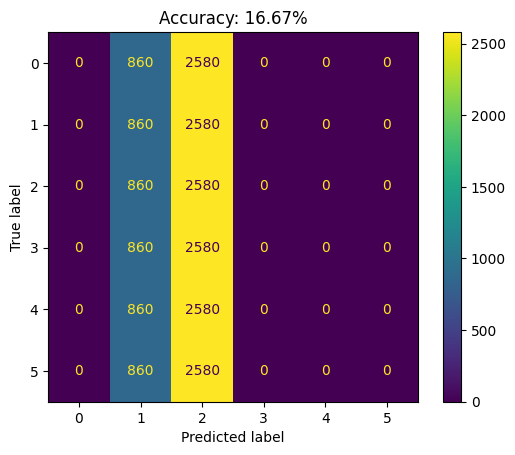

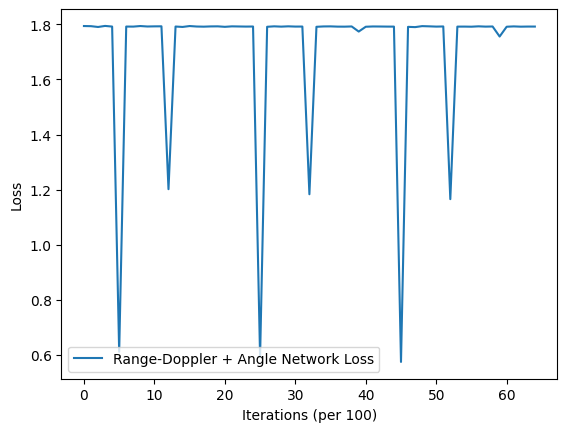

In [9]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm
#from model import ResNet, ResidualBlock
#from dataset import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt


if __name__=="__main__":
    device=torch.device('cuda:0')
    #trial_list=glob.glob(data_dir + '/Dataset/car/Range_Doppler_Angle_img/4.11_img_data/*')
    trial_list=glob.glob(data_dir + '/Dataset/outdoor/Range_Doppler_Angle_img/*')
    ds_train = dataset_range_dop_ang_train(rnn_length=16, trial_list=trial_list)
    dl_train = DataLoader(ds_train, batch_size=8,shuffle=True,drop_last=True,num_workers=2,prefetch_factor=2)

    ds_eval = dataset_range_dop_ang_eval(rnn_length=16, trial_list=trial_list)
    net = CNN_LSTM_rd_a(ResNet(ResidualBlock,[2, 2, 2, 2])).to(device)
    optimizer=torch.optim.Adam(net.parameters(),lr=0.001,betas=(0.9, 0.999))
    epoch_num=10
    iteration=0
    max_acc = 0.0
    new_acc = 0.0
    loss_running_record = []
    for epoch in range(epoch_num):
        running_loss = 0.0
        print("---------------epoch: {}----------------".format(epoch+1))
        for _, (images, labels) in enumerate(dl_train):
            #print(images)
            images=images.to(device).float()
            labels=labels.to(device)
            net.train()
            optimizer.zero_grad()
            #print(images)
            pred = net(images)
            criterion = nn.CrossEntropyLoss()
            
            labels = labels.view(-1)
            #print(labels)
            #print(pred.view(-1,6))
            #print(labels.to(torch.long))
            loss = criterion(pred.view(-1,6), labels.to(torch.long))
            #loss = criterion(pred.view(-1,5), labels.to(torch.long))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if iteration %100==0:
                loss_running_record.append(running_loss/100)    # record the loss
                print("iteration:{}, loss:{:5f}".format(iteration,loss.item()))
                running_loss = 0.0
            if iteration%1000==0:
                net.eval()
                correct = 0
                total = 0
                label_list=[]
                pred_list=[]

                correct_train = 0
                total_train = 0
                label_list_train=[]
                pred_list_train=[]
                with torch.no_grad():
                    for trial_no in range(len(ds_eval)):
                        eval_img_array, eval_label_array, train_img_array, train_label_array = ds_eval[trial_no]
                        eval_img_array=torch.from_numpy(eval_img_array[np.newaxis,...]).to(device).float()
                        eval_pred=net(eval_img_array)
                        eval_pred=torch.softmax(eval_pred,-1)
                        _, eval_pred=torch.max(eval_pred.data, 2)
                        total += eval_label_array.shape[0]
                        eval_pred=eval_pred.view(-1).cpu().numpy()
                        label_list+=eval_label_array.tolist()
                        pred_list+=eval_pred.tolist()
                        correct += np.sum((eval_pred == eval_label_array))

                        # train_img_array=torch.from_numpy(train_img_array[np.newaxis,...]).to(device).float()
                        # train_pred=net(train_img_array)
                        # train_pred=torch.softmax(train_pred,-1)
                        # _, train_pred=torch.max(train_pred.data, 2)
                        # total_train += train_label_array.shape[0]
                        # train_pred=train_pred.view(-1).cpu().numpy()
                        # label_list_train+=train_label_array.tolist()
                        # pred_list_train+=train_pred.tolist()
                        # correct_train += np.sum((train_pred == train_label_array))


                print("eval_accuary:{:5f}".format(correct/total))
                new_acc = correct/total
                #print("accuary_train:{:5f}".format(correct_train / total_train))
                if new_acc > max_acc:
                    max_acc = new_acc
                    state = {
                        'model_gs': net.state_dict(),
                        'optimizer_gs': optimizer.state_dict(),
                    }
                    torch.save(state, data_dir + '/rda_model/batch_{:05d}.pth'.format(iteration) )
                    # torch.save(state, './')
                    cm=confusion_matrix(label_list, pred_list)
                    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                    disp.plot()
                    disp.ax_.set_title(f'Accuracy: {((correct/total)*100):.2f}%')
                    # plt.show()
                    plt.savefig(data_dir + "/plots/plots1_rda_10epochs/{:05d}_cm.png".format(iteration))
                    
                #plt.savefig("./")
            # if iteration % 1000 == 0:
            #     state = {
            #         'model_gs': net.state_dict(),
            #         'optimizer_gs': optimizer.state_dict(),
            #     }
            #     torch.save(state, data_dir + '/rda_model/batch_{:05d}.pth'.format(iteration) )
            #     # torch.save(state, './')
            iteration+=1

    plt.figure()     
    plt.plot(loss_running_record[2:], label='Range-Doppler + Angle Network Loss')
    plt.legend()
    plt.xlabel('Iterations (per 100)')
    plt.ylabel('Loss')
    plt.savefig(data_dir + "/plots/plots1_rda_10epochs/total_loss.png")
    plt.show()

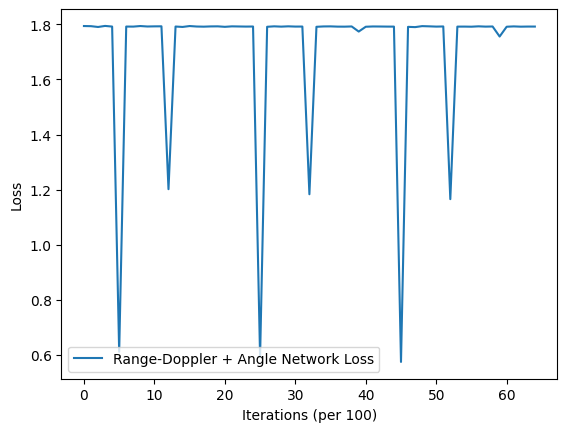

In [10]:
plt.figure()     
plt.plot(loss_running_record[2:], label='Range-Doppler + Angle Network Loss')
plt.legend()
plt.xlabel('Iterations (per 100)')
plt.ylabel('Loss')
plt.savefig(data_dir + "/plots/plots1_rda_10epochs/total_loss(1).png")
plt.show()